In [1]:
from RBM_surrogate import *
from Sampling_Quantum import *
from Sampling import *
from functools import partial

In [2]:
import seaborn as sns

In [3]:
from importlib import reload

In [11]:
N = 5
M = 2
rbm = RBM_surrogate(N,M)
rbm.build_surrogate()
prob_func = partial(prob_Ising_nv, N=N, poly=rbm.poly)  #, log_rho_max=rbm.log_rho_max)

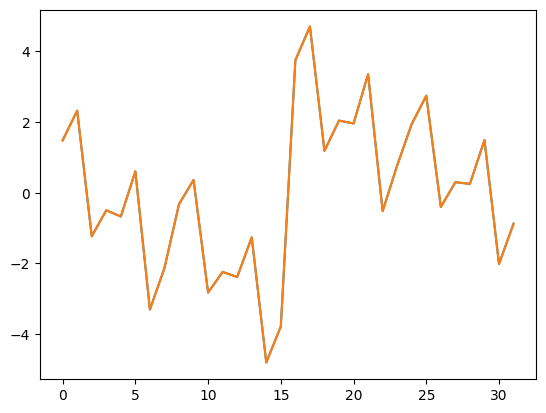

In [7]:
## Hamiltonian Diagonal Match Test 

s = enum(N)
gamma = 0

l = rbm.poly[1:1+N] 
J = rbm.poly[1+N:].reshape(N, N) 
alpha = computing_norm_ratio(N, l, J)
plt.plot(alpha * Energy_Ising(s,N,rbm.poly))

full_Ham_mat = Learner_Ham(N, rbm.poly, gamma, type_of_Ham="with_mixer").to_matrix()  
plt.plot(np.real(np.diag(full_Ham_mat)))

### Spectral Gap Test

In [8]:
def get_abs_spectral_gap_from_transition_mat(Transition_mat):
    dist = np.sort(1-np.abs(scipy.linalg.eigvals(Transition_mat)))
    delta = np.min(dist[1:])

    return delta

In [9]:
def run_experiment(N, trials=100, beta=1):
    s = enum(N)
    quantum_gaps = []
    uniform_gaps = []

    for _ in range(trials):
        poly = np.zeros(1+N+N*N)
        poly[1:1+N] = np.random.randn(N)
        J = np.random.randn(N,N)
        J = (J + J.T) / 2
        poly[1+N:] = J.reshape(-1)

        Energy = Energy_Ising(s, N, poly)

        gamma, tot_time = np.random.uniform(0.25, 0.6), np.random.uniform(2, 20)

        full_Ham_mat = Learner_Ham(N, poly, gamma, type_of_Ham="with_mixer").to_matrix()  
        U_t = scipy.linalg.expm(1.0j*tot_time*full_Ham_mat)

        Proposal_quantum = np.abs(U_t)**2
        Transition_quantum = np.abs(get_transition_matrix_from_proposal(N, Proposal_quantum, Energy, acceptance_criteria='metropolis', beta=1))
        quantum_gaps.append(get_abs_spectral_gap_from_transition_mat(Transition_quantum))

        Proposal_uniform = np.ones((2**N,2**N))/(2**N)
        Transition_uniform = np.abs(get_transition_matrix_from_proposal(N, Proposal_uniform, Energy, acceptance_criteria='metropolis', beta=1))
        uniform_gaps.append(get_abs_spectral_gap_from_transition_mat(Transition_uniform))

    return quantum_gaps, uniform_gaps

In [ ]:
quantum_gaps, uniform_gaps = run_experiment(8,100)

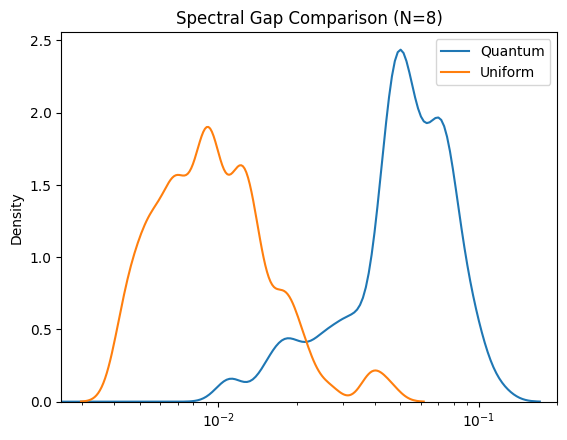

In [ ]:
sns.kdeplot(quantum_gaps, bw_adjust=0.5, log_scale=True, label="Quantum")
sns.kdeplot(uniform_gaps, bw_adjust=0.5, log_scale=True, label="Uniform")
plt.legend()
plt.title("Spectral Gap Comparison (N=8)")
plt.xlim((2.5e-3,0.2))
plt.show()

### Sampling Comparison

In [ ]:
N = 6
M = 2
rbm = RBM_surrogate(N,M)
rbm.build_surrogate()
prob_func = partial(prob_Ising_nv, N=N, poly=rbm.poly)  #, log_rho_max=rbm.log_rho_max)

In [50]:
sample_size = 80000


tm = time.time()
s = rbm.enum(N)
exact_dist = rbm.prob(s)
exact_dist = exact_dist / np.sum(exact_dist)
#plt.plot(1/4 - exact_dist)
print("Exact",  time.time()-tm)

prob_dist = {}
tm = time.time()
prob_dist['uniform'] = Sampling(N=N, prob_func=prob_func, sample_size=sample_size, burn=sample_size//10)
print("Uniform Sampling", time.time()-tm)

tm = time.time()
prob_dist['prop_exact'] = Sampling_Quantum(N=N, poly=rbm.poly, sample_size=sample_size, burn=sample_size//10, compute_proposal_matrix=True, mode='Exact')
print("Proposal Matrix Exact", time.time()-tm)

tm = time.time()
prob_dist['prop_trot'] = Sampling_Quantum(N=N, poly=rbm.poly, sample_size=sample_size, burn=sample_size//10, compute_proposal_matrix=True, mode='Trotter')
print("Proposal Matrix Trotter", time.time()-tm)


Exact 0.002628326416015625
Uniform Sampling 9.309424877166748
Proposal Matrix Exact 0.7229628562927246
Proposal Matrix Trotter 1.3555731773376465


In [ ]:
sample_size = 10000 #80000
tm = time.time()
prob_dict, _ = Sampling_Quantum(N=N, poly=rbm.poly, sample_size=sample_size, burn=sample_size//10)
print("Quantum Sampling", time.time()-tm)

Quantum Sampling 220.00312066078186


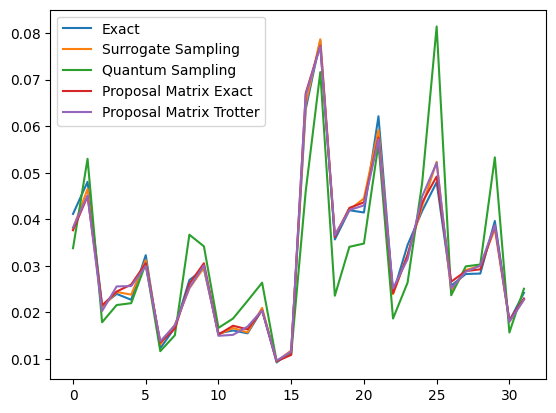

In [51]:
plt.plot(exact_dist, label='Exact')
plt.plot(prob_dist['uniform'], label="Surrogate Sampling")
plt.plot(prob_dict.values(), label="Quantum Sampling")
plt.plot(prob_dist['prop_exact'], label="Proposal Matrix Exact")
plt.plot(prob_dist['prop_trot'], label="Proposal Matrix Trotter")

plt.legend()
plt.show()

### Quantum Sampler Test

In [56]:
key_list = {'Trotter': [], 'Quantum': []}

In [ ]:

tot_time=12
time_delta=0.5
gamma=0.42

init_config = np.array([1,1,-1,-1,1])

angles_u3, angles_2q = compute_angles(rbm.poly, N, time_delta, gamma)
k = int(tot_time / time_delta)

for _ in range(8000):
    s = quantum_sampler(N,rbm.poly,init_config,k,angles_u3,angles_2q)
    key = spin_to_key_nv(s)
    key_list['Quantum'].append(key)

In [71]:
U_t = np.zeros((2**N, 2**N), dtype=np.complex128)

for key in range(2**N):
    s = key_to_spin_nv(key, N)
    angles_ry = np.flip(np.pi*(1-s)/2)

    U_t[:, key] = (np.array(cudaq.get_state(
                Trotter_circuit, N, k, angles_ry, angles_u3, np.reshape(angles_2q,-1)), copy=False))

Proposal_mat =  np.abs(U_t)**2  
#Proposal_mat = np.ones((2**N,2**N))/(2**N)

s = enum(N)
Energy = Energy_Ising(s, N, rbm.poly)
Transition_matrix = np.abs(get_transition_matrix_from_proposal(N, Proposal_mat, Energy, acceptance_criteria='metropolis', beta=1))

In [ ]:
key = spin_to_key_nv(init_config)

for _ in range(sample_size):
    new_key = np.random.choice(np.arange(2**N), p=Transition_matrix[:,key])
    key_list['Trotter'].append(new_key)


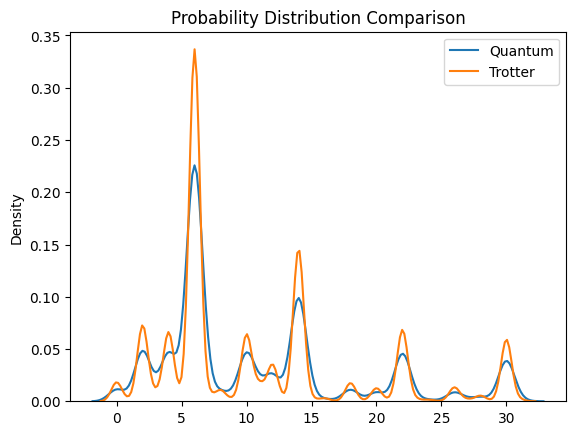

In [82]:
sns.kdeplot(key_list['Quantum'], bw_adjust=0.5, label="Quantum")
sns.kdeplot(key_list['Trotter'], bw_adjust=0.5, label="Trotter")
plt.legend()
plt.title("Probability Distribution Comparison")
#plt.xlim((2.5e-3,0.2))
plt.show()

In [83]:
len(key_list['Trotter']), len(key_list['Quantum'])

(80000, 10000)